Reproduce Figure 3.6 on bias-variance trade off (scale parameter for the Gaussian is not mentioned in the text).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(42)  # set the seed for reproducibility

# Prepare data

## Generate training data set

In [3]:
# generate test data
L = 100        # number of data sets
N_train = 25   # number of points in each data set
sigma = 0.3    # s.d. of the Gaussian noise

In [4]:
# x and h are same for all the training data sets so only generate once
x_train = np.linspace(0, 1, N_train)
h = np.sin(2 * np.pi * x_train)  # ground truth sinusoidal curve
x_train.shape, h.shape

((25,), (25,))

In [5]:
t_train = h + sigma * np.random.randn(L, N_train)
t_train.shape  # (L, N_train)

(100, 25)

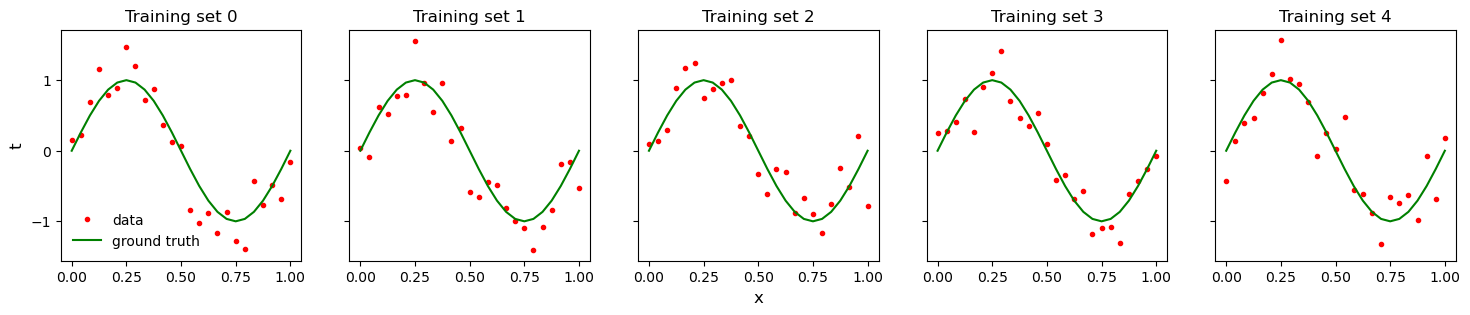

In [6]:
# plot example training data set
fig, ax = plt.subplots(1, 5, figsize=(18, 3), sharey=True)
for i in range(5):
    ax[i].plot(x_train, t_train[i].T, 'r.', label='data')
    ax[i].plot(x_train, h, 'g', label='ground truth')
    ax[i].set_title(f'Training set {i}')
ax[2].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('t', fontsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].legend(frameon=False,loc='lower left')
plt.show()

## Generate test data set

Note that the ground truth $h(x)$ is not available for the test data set.

In [7]:
N_test = 1000  # number of points in each data set

In [8]:
x_test = np.linspace(0, 1, N_test)
x_test.shape

(1000,)

In [9]:
t_test = np.sin(2 * np.pi * x_test) + sigma * np.random.randn(L, N_test)
t_test.shape  # (L, N_test)

(100, 1000)

# Analysis

In [10]:
num_gauss = 24     # number of Gaussian basis function (not including the bias)
M = num_gauss + 1  # total number of parameters including the bias term
s = 0.05           # scale parameter of the Gaussian basis function

In [11]:
def phi(x, mu, s):
    """apply Gaussian basis function
    
    Args:
        x (np.array): input
        mu (float): location parameter
        s (float): scale parameter
        
    Returns:
        phi_i(x) (np.array)
    """
    return np.exp(- (x - mu) ** 2 / (2 * s ** 2))

In [12]:
def create_design_matrix(x, num_gauss, s):
    """create a design matrix for polynomial regression
    
    Args:
        x (np.array): observations (N, )
        num_gauss (int): number of Gaussian basis function (not including the bias)
        s (float): scale paramter of the Gaussian basis function
    
    Returns:
        Phi (np.array): design matrix in PRML (3.16), (N, M)
    """
    mu_array = np.linspace(0, 1, num_gauss)
    Phi = []
    for m in range(num_gauss):
        if m == 0:  # bias term
            Phi.append(np.ones(len(x), ))
        Phi.append(phi(x, mu_array[m], s))
    Phi = np.array(Phi).T
    return Phi

In [13]:
# testing the design matrix
Phi = create_design_matrix(x_test, num_gauss, s)
Phi.shape  # (N_test, M)

(1000, 25)

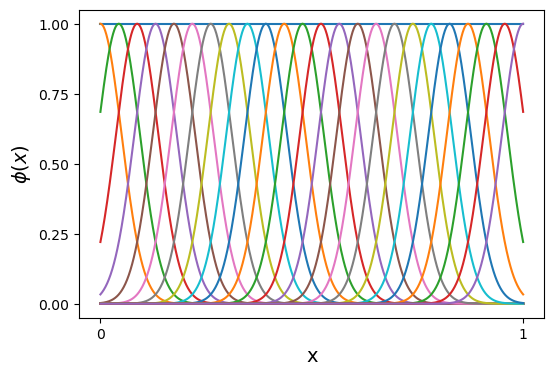

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x_test, Phi)
ax.set_xticks([0, 1])
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel(r'$\phi(x)$', fontsize=14)
plt.show()

In [15]:
def solve_normal_equation(Phi, t_train, ln_lambda):
    """solve the normal equation for linear reqression (3.15)
    
    Args:
        Phi (np.array): design matrix (N, M)
        t (np.array): target values (N, )
        ln_lambda (float): natural log of the regularization parameter
    
    Returns:
        w_ML (np.array): coefficients including the bias term (M, )
    """
    lambda_ = np.exp(ln_lambda)  # regularization parameter
    M = Phi.shape[1]
    A = lambda_ * np.eye(M) + Phi.T @ Phi
    B = Phi.T @ t_train
    w_ML = np.linalg.solve(A, B)  # faster and numerically more stable than np.linalg.inv
    
    return w_ML

In [16]:
def poly_fit(x_train, t_train, num_gauss, s, ln_lambda):
    """
    Args:
        x_train (np.array): inputs (N_train, )
        t_train (np.array): target values (N_train, )
        x_test (np.array): input values for making predictions (N_test, )
        num_gauss (int): number of Gaussian basis functions
        s (float): scale parameter of the Gaussian basis functions
        ln_lambda (float): natural log of theregularization paramter
        
    Returns:
        t_train_pred (np.array): predicted values for the x_train (N_train, )
        t_test_pred (np.array): predicted values for x_test (N_test, )
        w_ML (np.array): coefficients (M, 1)
    """
    # maximum likelihood estimation
    Phi = create_design_matrix(x_train, M, s)
    w_ML = solve_normal_equation(Phi, t_train, ln_lambda)
    
    # predictions for the training data set
    y_train_pred = Phi @ w_ML
    
    return y_train_pred, w_ML

In [17]:
def multiple_fits_with_test(x, t, h, x_test, t_test, num_gauss, s, ln_lambda):
    """perform multiple fits over the entire dataset
    
    Args:
        x (np.array): inputs (N, )
        t (np.array): targets (L, N)
        h (np.array): ground truth (N, )
        x_test (np.array): inputs (N_test, )
        t_test (np.array): targets (L, N_test)
        num_gauss (int): number of Gaussian basis functions
        ln_lambda (float): regularization parameter
    
    Returns:
        Y_train (np.array): predictions for the training data (L, N)
        Y_test (np.array): predictions for the test data (L, N_test)
    """
    
    Y_train = []
    Y_test = []
    for l in range(L):
        t_train_pred, w_ML = poly_fit(x, t[l], num_gauss, s, ln_lambda)  
        Phi_test = create_design_matrix(x_test, M, s)
        t_test_pred = Phi_test @ w_ML
        
        Y_train.append(t_train_pred)
        Y_test.append(t_test_pred)

    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    
    y_bar = Y_train.mean(axis=0)
    bias_sq = np.mean((y_bar - h) ** 2)
    var = ((Y_train - y_bar) ** 2).mean(axis=0).mean()
    test_err = ((Y_test - t_test) ** 2).mean(axis=0).mean()
    
    return Y_train, bias_sq, var, test_err

# Calculate bias-variance trade off

In [18]:
ln_lambda_list = np.linspace(-2.5, 1.8, 50)
bias_list = []
var_list = []
test_list = []
for ln_lambda in ln_lambda_list:
    _, bias_sq, var, test_err = multiple_fits_with_test(x_train, t_train, h, x_test, t_test, num_gauss, s, ln_lambda)
    bias_list.append(bias_sq)
    var_list.append(var)
    test_list.append(test_err)

bias = np.array(bias_list)
var = np.array(var_list)
bias_var = bias + var

In [19]:
ln_lambda_list[np.argmin(bias_var)]

-0.042857142857142705

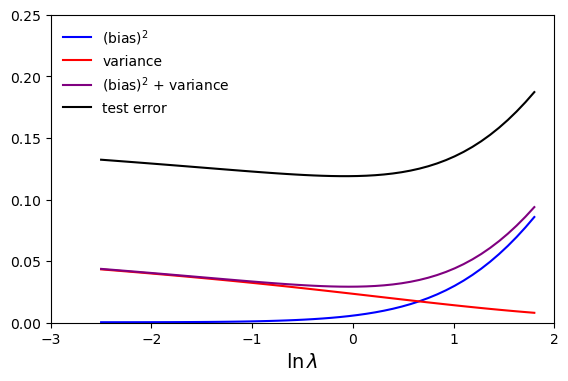

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
ax.plot(ln_lambda_list, bias, 'b', label=r'(bias)$^2$')
ax.plot(ln_lambda_list, var, 'r', label='variance')
ax.plot(ln_lambda_list, bias_var, 'purple', label=r'(bias)$^2$ + variance')
ax.plot(ln_lambda_list, test_list, 'k', label='test error')
ax.set_xlim(-3, 2)
ax.set_ylim(0, 0.25)
ax.set_xticks(np.arange(-3, 3, 1))
ax.set_yticks(np.arange(0, 0.3, 0.05))
ax.set_xlabel(r'$\ln \lambda$', fontsize=14)
plt.legend(frameon=False, loc='upper left')
plt.show()